---
# Group statistics of pRF overlap

In [6]:
%matplotlib inline

In [2]:
from linescanning import (
    utils,
    plotting,
    prf,
    dataset,
    preproc,
    glm,
    optimal,
    fitting
)
from datetime import datetime
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import io, stats
import pandas as pd
import pRFline
from pRFline.plotting import pRFSpread
from pRFline.utils import SubjectsDict
import seaborn as sns
opj = os.path.join
opd = os.path.dirname

221031-08:57:51,952 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.8.2


In [3]:
# Load data
ses         = 2
task        = "task-pRF"
base_dir    = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF"
design_dir  = opj(opd(opd(pRFline.__file__)), "data")
fig_dir     = opj(opd(opd(pRFline.__file__)), "results")

In [4]:
verbose = False
fix_bold = True
model = "norm"
fit_nbr = True
downsample = False
nbr_r2_thresh = 0.1

# fetch subject dictionary from pRFline.utils.SubjectsDict
subj_obj = SubjectsDict()
dict_data = subj_obj.dict_data


## Main data parser

Same loop as `overlap.py`, but because everything is run already, it just reads in the existing files

In [5]:
full_dict = {}

process_subjs = list(dict_data.keys())
# process_subjs = ["sub-002", "sub-003","sub-007","sub-008"]

for subject in process_subjs:

    data_output = opj(design_dir, subject)
    
    # initiate dictionary
    full_dict[subject] = {}

    print("\n---------------------------------------------------------------------------------------------------")
    print(f"Dealing with {subject} [{datetime.now().strftime('%Y/%m/%d %H:%M:%S')}]")
    print("\n-- linescanning --")

    # add line-scanning key
    full_dict[subject]["lines"] = {}

    ####################################################################################################
    # LINE-SCANNING BIT
    ####################################################################################################

    #---------------------------------------------------------------------------------------------------
    # get directories
    func_dir    = opj(base_dir, subject, f"ses-{ses}", "func")
    anat_dir    = opj(os.path.dirname(func_dir), 'anat')

    run_files   = utils.get_file_from_substring(
        [subject, f"ses-{ses}", f"{task}"], 
        func_dir, 
        exclude=dict_data[subject]["exclude"])
        
    func_file = utils.get_file_from_substring("bold.mat", run_files)
    anat_slices = utils.get_file_from_substring([subject, f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir)
    ref_slices  = utils.match_lists_on(func_file, anat_slices, matcher='run')

    # mind you, the segmentations live in ses-1 space, NOT FREESURFER!
    ses_to_motion = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(base_dir, "derivatives", 'pycortex', subject, 'transforms'))
    run2run = utils.get_file_from_substring(['.txt'], anat_dir)

    #---------------------------------------------------------------------------------------------------
    # PREPROCESSING

    print("Reading in data")
    data_obj = dataset.Dataset(
        func_file,
        use_bids=True,
        verbose=verbose,
        acompcor=True,
        ref_slice=ref_slices,
        ses1_2_ls=ses_to_motion,
        run_2_run=run2run,
        n_pca=5,
        deleted_last_timepoints=300,
        report=False)

    df_func = data_obj.fetch_fmri()

    # select ribbon voxels
    df_ribbon = utils.select_from_df(
        df_func, 
        expression="ribbon", 
        indices=dict_data[subject]["ribbon"])

    # average runs
    avg_psc = df_ribbon.groupby(['subject', "t"]).mean().values.mean(axis=-1)[np.newaxis,:]

    process_data = ["native"]
    if downsample:
        process_data += ["ds"]

    for res in process_data:

        print(f"Dealing with '{res}' as temporal resolution")
        full_dict[subject]["lines"][res] = {}

        # get low-res design 
        dm_f = opj(data_output, f"{subject}_acq-lines_res-{res}_desc-full_design.mat")
        if os.path.exists(dm_f):
            print(f" Reading {dm_f}")
            dm_ = prf.read_par_file(dm_f)               

        input_data = avg_psc.copy()
        tr = 0.105
        if res == "ds":
            tr = 1.5
            new_vols = int((avg_psc.shape[-1]*0.105)/tr)
            input_data = glm.resample_stim_vector(avg_psc.T, new_vols).T

        # sync design matrix and data shapes
        sync_dm = dm_[...,:input_data.shape[-1]]     

        avg_l = prf.pRFmodelFitting(
            input_data,
            design_matrix=sync_dm,
            model=model,
            TR=tr,
            fix_bold_baseline=fix_bold,
            verbose=verbose,
            rsq_threshold=0,
            screen_distance_cm=196,
            grid_nr=40,
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-lines_res-{res}_vox-avg"
        )

        pars_file = opj(avg_l.output_dir, f"{avg_l.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" Fitting {res} avg ribbon")
            print(f"  TR = {tr}; ")
            print(f"  data shape = {input_data.shape}")
            print(f"  design shape = {sync_dm.shape}")
            avg_l.fit()    
        else:
            print(f" Reading {pars_file}")
            avg_l.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["lines"][res] = {}
        full_dict[subject]["lines"][res]["avg"] = avg_l

        # fit across laminae
        input_data = df_ribbon.groupby(['subject', "t"]).mean().values

        vox_ = prf.pRFmodelFitting(
            input_data.T,
            design_matrix=sync_dm,
            model=model,
            TR=tr,
            fix_bold_baseline=fix_bold,
            verbose=verbose,
            rsq_threshold=0,
            screen_distance_cm=196,
            grid_nr=40,
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-lines_res-{res}_vox-ribbon",
            old_params=getattr(avg_l, f"{model}_iter"),
            fix_parameters=[0,1],
            fit_hrf=True
        )

        pars_file = opj(vox_.output_dir, f"{vox_.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" Fitting {res}-ribbon", flush=True)
            print(f"  data shape = {input_data.shape}", flush=True)
            print(f"  design shape = {sync_dm.shape}", flush=True)
            # vox_.fit()
        else:
            print(f" Reading {pars_file}", flush=True)
            vox_.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["lines"][res]["ribbon"] = vox_

    print("Done", flush=True)

    ####################################################################################################
    # 2D-EPI WHOLE-BRAIN BIT
    ####################################################################################################

    print("\n-- whole brain 2D-EPI --")
    
    # add whole-brain key
    full_dict[subject]["wb"] = {}
    full_dict[subject]["vertices"] = {}
    full_dict[subject]["vertices"]["target"] = dict_data[subject]['target']

    # check if we should fit neighbouring voxels of target
    fit_verts = [dict_data[subject]['target']]
    if fit_nbr:
        # fit_verts = subj_obj.get_neighbours(subject=subject, vertices_only=True)
        
        nbr = optimal.Neighbours(
            subject=subject,
            hemi="lh",
            verbose=True
        )

        # read in the distance file; created with `call_distance`
        dist_file = opj(data_output, f"{subject}_hemi-L_desc-V1_distances.json")
        if not os.path.exists(dist_file):
            raise FileNotFoundError(f"Could not find file with distances. Create it with 'call_distance'")

        nbr.distances_to_target(vert_dict=dist_file, hemi="lh")

        mm2 = nbr.find_distance_range(vmax=2)
        mm2_4 = nbr.find_distance_range(vmin=2,vmax=4)
        mm4_6 = nbr.find_distance_range(vmin=4,vmax=6)

        fit_verts = sorted(fit_verts+mm2+mm2_4+mm4_6)

        mm2_idx,mm2_4_idx,mm4_6_idx = [],[],[]
        for ix,vert in enumerate(fit_verts):
            if vert != subj_obj.get_target(subject):
                if vert in mm2:
                    mm2_idx.append(ix)
                elif vert in mm2_4:
                    mm2_4_idx.append(ix)
                elif vert in mm4_6:
                    mm4_6_idx.append(ix)

        full_dict[subject]["vertices"]["2mm"] = mm2_idx.copy()
        full_dict[subject]["vertices"]["4mm"] = mm2_4_idx.copy()
        full_dict[subject]["vertices"]["6mm"] = mm4_6_idx.copy()

        print(f"Fitting {len(fit_verts)-1} neighbouring vertices + target vertex {subj_obj.get_target(subject)}", flush=True)

    full_dict[subject]["vertices"]["all"] = fit_verts

    # get directories
    data_dir = opj(base_dir, "derivatives", "pybest", subject, "ses-1", "unzscored")
    data_files = utils.get_file_from_substring("npy", data_dir, exclude="hemi-R")
    design = utils.resample2d(prf.read_par_file(opj(base_dir, "derivatives", "prf", subject, "ses-1", "design_task-2R.mat")), new_size=100)

    # remove first 4 volumes
    cut_vols = 4
    design_cut = design.copy()[...,cut_vols:]

    collect_vox = []
    for ix,data in enumerate(data_files):

        full_dict[subject]["wb"][ix] = {}
        
        # get target vertex data
        vox_data = np.load(data)[cut_vols:,fit_verts]

        # convert to percent change
        vox_psc = utils.percent_change(vox_data, 0, baseline=15)

        # append
        collect_vox.append(vox_psc[...,np.newaxis])

        # fit
        fit_ = prf.pRFmodelFitting(
            vox_psc.T,
            design_matrix=design_cut,
            fix_bold_baseline=fix_bold,
            model=model,
            verbose=verbose,
            rsq_threshold=0,
            TR=1.5,
            screen_distance_cm=210,
            screen_size_cm=dict_data[subject]["screen_size"],
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-2DEPI_run-{ix+1}"
        )

        pars_file = opj(fit_.output_dir, f"{fit_.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" fitting run-{ix+1} [data={fit_.data.shape}]..", flush=True)
            fit_.fit()
        else:
            print(f" reading run-{ix+1}..", flush=True)
            fit_.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["wb"][ix] = fit_

    # average
    collect_vox = np.concatenate(collect_vox, axis=-1)
    avg = np.median(collect_vox, axis=-1)

    # fit average
    avg_epi = prf.pRFmodelFitting(
        avg.T,
        design_matrix=design_cut,
        fix_bold_baseline=fix_bold,
        model=model,
        verbose=verbose,
        rsq_threshold=0,
        TR=1.5,
        screen_distance_cm=210,
        screen_size_cm=dict_data[subject]["screen_size"],
        write_files=True,
        save_grid=False,
        output_dir=data_output,
        output_base=f"{subject}_acq-2DEPI_run-avg"
    )

    pars_file = opj(avg_epi.output_dir, f"{avg_epi.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
    if not os.path.exists(pars_file):
        print(f" fitting run-avg [data={avg_epi.data.shape}]..", flush=True)
        avg_epi.fit()
    else:
        print(f" reading run-avg..", flush=True)
        avg_epi.load_params(
            pars_file, 
            model=model, 
            stage="iter")

    full_dict[subject]["wb"]['avg'] = avg_epi

    print("Done")


---------------------------------------------------------------------------------------------------
Dealing with sub-001 [2022/10/31 08:58:00]

-- linescanning --
Reading in data
Dealing with 'native' as temporal resolution
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_acq-lines_res-native_desc-full_design.mat
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_acq-lines_res-native_vox-avg_model-norm_stage-iter_desc-prf_params.pkl
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_acq-lines_res-native_vox-ribbon_model-norm_stage-iter_desc-prf_params.pkl
Done

-- whole brain 2D-EPI --
Initializing SurfaceCalc
Creating subsurfaces for V1_exvivo.thresh
Reading distances from /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data/sub-001/sub-001_hemi-L_desc-V1_distances.json
Fitting 169 neighbouring vertices + target vertex 1053
 reading run-1.

## Main summary plot

Contains:

- row of subject-specific plots in visual space with the EPI-runs (grey circles), average EPI (black circle) and the average line pRF across the ribbon (subject-specific color)
- plot of normalized pRFs for all subjects
- r2 for various flavours (e.g., average EPI, EPI-runs, average line)
- Distance to average EPI (from EPI runs, 2mm away, 4mm away, 6mm away and the average line pRF)

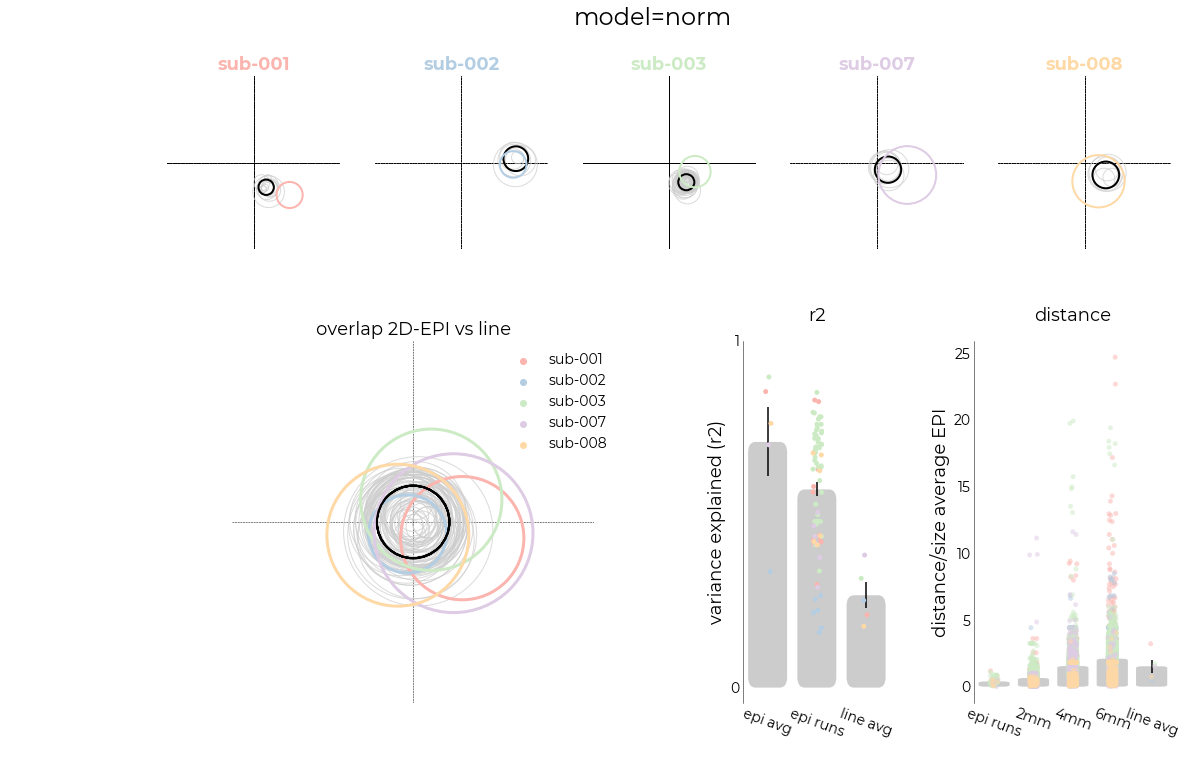

In [35]:
# figure settings
fig = plt.figure(figsize=(18,10))
subfigs = fig.subfigures(nrows=2, height_ratios=[0.5,1])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=3, 
    gridspec_kw={
        'width_ratios': [1,0.3,0.4], 
        'wspace': 0.3})

# axis for pRF overlap plot
axs = axs_avg[0]

colors=["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])

subjects = list(full_dict.keys())
cmap_subj = "Pastel1"
sub_colors = sns.color_palette(cmap_subj, len(subjects))

r2s, dist = {},{}
r2s["subject"], r2s["r2"], r2s["acq"], r2s["name"] = [],[],[],[]
dist["subject"], dist["distance"], dist["acq"], dist["name"] = [],[],[],[]

# if fit_nbr == True, target vertex is last row
est_idx = 0

for ix,sub in enumerate(subjects):

    ax_ = axs_subj[ix]

    for fit in full_dict[sub]['wb']:
        
        # find index of target 
        est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]
        
        if fit != "avg":
            # get parameters from individual runs
            pars,_,_,_ = full_dict[sub]['wb'][fit].plot_vox(
                vox_nr=est_idx,
                model=model,
                stage='iter',
                make_figure=False
            )

            if pars[-1] != 0:
                # get parameters from average
                avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
                    vox_nr=est_idx,
                    model=model,
                    stage='iter',
                    make_figure=False
                )

                # express distance as distance/size
                dist_dva = prf.distance_centers(avg_pars,pars)/avg_pars[2]
                dist["distance"].append(dist_dva)
                dist["subject"].append(sub)
                dist["name"].append("epi runs")
                dist["acq"].append(0)                

                # append r2 to dictionary
                r2s["r2"].append(pars[-1])
                r2s["subject"].append(sub)
                r2s["name"].append("epi runs")
                r2s["acq"].append(1)
                
            # get distance/size of neighbouring vertices
            if fit_nbr:
                nbr_pars = getattr(full_dict[sub]['wb'][fit], f"{model}_iter")
                for nbr in range(nbr_pars.shape[0]):
                    
                    # filter out target vertex
                    if full_dict[sub]["vertices"]["all"][nbr] != full_dict[sub]["vertices"]["target"]:

                        # get parameters from neighbours
                        nbr_estimates = nbr_pars[nbr,:]

                        # plot normalized neighbour
                        nbr_norm = prf.normalize_prf(avg_pars,nbr_estimates)

                        # find x/y of max pRF
                        center = (nbr_norm[0],nbr_norm[1])
                        circ_nbr = plt.Circle(
                            center,
                            nbr_norm[2],
                            ec="r",
                            fill=False,
                            alpha=0.15)
                        # axs.add_artist(circ_nbr)      
                        
                        if nbr in full_dict[sub]["vertices"]["2mm"]:
                            nn = "2mm"
                            ct = 1
                        elif nbr in full_dict[sub]["vertices"]["4mm"]:
                            nn = "4mm"
                            ct = 2
                        elif nbr in full_dict[sub]["vertices"]["6mm"]:
                            nn = "6mm"
                            ct = 3

                        dist_dva = prf.distance_centers(avg_pars,nbr_estimates)/avg_pars[2]
                        dist["distance"].append(dist_dva)
                        dist["subject"].append(sub)
                        dist["name"].append(nn)
                        dist["acq"].append(ct)                                  

        else:
            r2s["r2"].append(getattr(full_dict[sub]['wb']['avg'], f"{model}_iter")[est_idx,-1])
            r2s["subject"].append(sub)
            r2s["name"].append("epi avg")
            r2s["acq"].append(0)            

        if fit == 0 and ix == 0:

            # create visual field delineation, plot on subject specific axis & average
            plotting.LazyPRF(
                np.zeros((500,500)), 
                [-5,5],
                ax=axs,
                cross_color="k",
                edge_color=None,
                shrink_factor=0.9,
                cmap=cmap1,
                vf_only=True)

        # draw empty visual field for subject
        plotting.LazyPRF(
            np.zeros((500,500)), 
            [-5,5],
            ax=ax_,
            cross_color="k",
            edge_color=None,
            shrink_factor=0.9,
            cmap=cmap1,
            vf_only=True)                

        if fit != "avg":
            # plot normalized pRF
            run_norm = prf.normalize_prf(avg_pars,pars)
            
            # find x/y of max pRF
            center = (run_norm[0],run_norm[1])
            circ2 = plt.Circle(
                center,
                run_norm[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)
        
            axs.add_artist(circ2)

            # add non-normalized to subject specific axis
            circ_run_subj = plt.Circle(
                (pars[0],pars[1]),
                pars[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)

            ax_.add_artist(circ_run_subj)

line_avg_idx_dist = len(np.unique(dist["acq"]))
for ix,sub in enumerate(subjects):

    #re-fetch the index of target vertex
    est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

    # get parameters from average
    avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
        vox_nr=est_idx,
        model=model,
        stage='iter',
        make_figure=False
    )

    circ_avg = plt.Circle(
        (0,0),
        1,
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    axs.add_artist(circ_avg)

    # add average line-scanning
    l_pars,_,_,_ = full_dict[sub]['lines']['native']["avg"].plot_vox(
        model=model,
        stage='iter',
        make_figure=False
    )

    # plot normalized pRF
    line_norm = prf.normalize_prf(avg_pars,l_pars)

    # find x/y of max pRF
    center = (line_norm[0],line_norm[1])
    circ3 = plt.Circle(
        center,
        line_norm[2],
        ec=sub_colors[ix],
        fill=False,
        lw=3)

    axs.add_artist(circ3)

    # add to subject specific axis
    sub_epi = plt.Circle(
        (avg_pars[0],avg_pars[1]),
        avg_pars[2],
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    sub_line = plt.Circle(
        (l_pars[0],l_pars[1]),
        l_pars[2],
        ec=sub_colors[ix],
        fill=False,
        lw=2)

    axs_subj[ix].add_artist(sub_epi)    
    axs_subj[ix].add_artist(sub_line)    

    # axs.annotate(sub, xy=center, fontsize=12, ha="center")
    axs_subj[ix].set_title(sub, fontsize=18, color=sub_colors[ix], fontweight="bold")
    axs.set_title("overlap 2D-EPI vs line", fontsize=18)
    
    # append to r2 array
    avg_idx = 2
    if downsample:
        l_ds_pars,_,_,_ = full_dict[sub]['lines']['ds'].plot_vox(
            model=model,
            stage='iter',
            make_figure=False
        )

        avg_idx = 3
        r2s["r2"].append(l_ds_pars[-1])
        r2s["subject"].append(sub)
        r2s["name"].append("line ds")
        r2s["acq"].append(2)        

    r2s["r2"].append(l_pars[-1])
    r2s["subject"].append(sub)
    r2s["name"].append("line avg")
    r2s["acq"].append(avg_idx)

    # append distance
    line_dist = prf.distance_centers(avg_pars, l_pars)/avg_pars[2]
    dist["distance"].append(line_dist)
    dist["subject"].append(sub)
    dist["name"].append("line avg")
    dist["acq"].append(line_avg_idx_dist)

# make dataframe
df_r2 = pd.DataFrame(r2s)
df_dist = pd.DataFrame(dist)

# enforce float
df_r2["r2"] = df_r2["r2"].astype(float)
df_dist["distance"] = df_dist["distance"].astype(float)
df_r2.head()

r2_axs = axs_avg[1]
dist_axs = axs_avg[2]

plotting.LazyBar(
    data=df_r2.sort_values(['acq','subject']),
    x="name",
    y="r2",
    sns_ori="v",
    axs=r2_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    points_cmap=cmap_subj,
    points_hue="subject",    
    y_label2="variance explained (r2)",
    title2="r2",
    ticks=[0,1],
    sns_rot=-20,
    fancy=True,
    trim_bottom=True
)

plotting.LazyBar(
    data=df_dist.sort_values(['acq','subject']),
    x="name",
    y="distance",
    sns_ori="v",
    axs=dist_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    y_label2="distance/size average EPI",
    points_cmap=cmap_subj,
    points_hue="subject",
    title2="distance",
    points_legend=True,
    bbox_to_anchor=(-1.8,1),
    sns_rot=-20,
    fancy=True,
    fancy_rounding=0.15,
    fancy_aspect=0.9,
    points_alpha=0.5,
    trim_bottom=True
)

fig.suptitle(f"model={model}", fontsize=24, y=1.05)

for ext in ['png','svg']:
    fig.savefig(
        opj(fig_dir, f"sub-all_model-{model}_desc-combined+subjects.{ext}"),
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

## Normalized HRFs

Below, the HRFs per subject across depth are plotted. The HRFs are normalized to their own maximum amplitude

In [12]:
normalize = False
hrfs = []
for ix,sub in enumerate(subjects):
    sub_hrfs = []
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
    for ii in range(fit_obj.norm_iter.shape[0]):
        
        # get the parameters
        hrf_pars = [1, *fit_obj.norm_iter[ii, -3:-1]]

        # create HRF depending on prfpy-branch
        try:
            hrf = fit_obj.hrf.create_spm_hrf(hrf_params=hrf_pars, TR=fit_obj.TR, force=True).T
        except:
            hrf = fit_obj.norm_model.create_hrf(hrf_params=hrf_pars).T
        
        # normalize to its own maximum
        if normalize:
            hrf /= hrf.max()

        # create time axis
        xx = list(np.arange(0,hrf.shape[0])*fit_obj.TR)

        # create dataframe
        df_hrf = pd.DataFrame(hrf, columns=["hrf"])
        df_hrf["subject"],df_hrf["t"],df_hrf["depth"] = sub,xx,ii

        sub_hrfs.append(pd.DataFrame(df_hrf))
    
    # append subject-specific HRFs
    hrfs.append(pd.concat(sub_hrfs))
    
# concatenate into single dataframe
hrf_df = pd.concat(hrfs).set_index(["subject","t","depth"])
hrf_df


hrf
subject t      depth              
sub-001 0.000  0      0.000000e+00
        0.105  0      1.386415e-20
        0.210  0      1.293898e-07
        0.315  0      3.555173e-06
        0.420  0      2.149346e-05
...                            ...
sub-008 39.480 5     -8.209563e-08
        39.585 5     -7.687313e-08
        39.690 5     -7.197537e-08
        39.795 5     -6.738267e-08
        39.900 5     -6.307653e-08

[14097 rows x 1 columns]

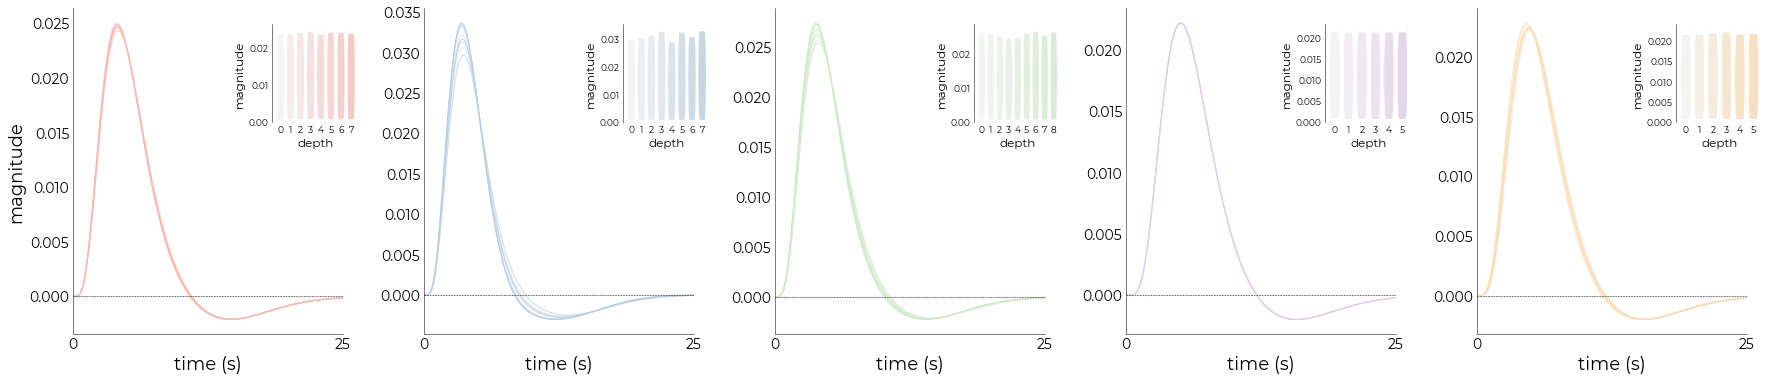

In [17]:
fig,axs = plt.subplots(ncols=len(dict_data),figsize=(6*len(dict_data),6), gridspec_kw={'wspace': 0.3})

plot_mag = True
plot_ttp = True
plot_fwhm = False

cmap = "viridis"
for ix,sub in enumerate(subjects):
    
    # get the pRF-object containing estimates across depth
    if "ribbon" in list(full_dict[sub]["lines"]["native"].keys()):
        
        fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

        # get subject-specific HRFs from HRF-dataframe  
        sub_hrf = utils.select_from_df(hrf_df, expression=f"subject = {sub}")

        # parse them into list depending on the number of voxels in estimates
        hrf_list = [utils.select_from_df(sub_hrf, expression=f"depth = {ii}")['hrf'].values for ii in range(fit_obj.norm_iter.shape[0])]

        # get subject specific color palette
        colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", len(hrf_list))
        y_ticks = None
        trim_left = False
        if ix == 0:
            if normalize:
                y_ticks = [0,1]
                trim_left = True

            y_lbl = "magnitude"
        else:
            if normalize:
                y_ticks = []

            y_lbl = None

        # create time axis
        time_axis = list(np.arange(0,hrf_list[0].shape[0])*fit_obj.TR)

        # plot
        plotting.LazyPlot(
            hrf_list,
            axs=axs[ix],
            xx=time_axis,
            x_label="time (s)",
            y_label=y_lbl,
            cmap=colors,
            x_lim=[0,25],
            x_ticks=[0,25],
            y_ticks=y_ticks,
            add_hline=0,
            trim_left=trim_left
        )
        
        # add time-to-peak across the ribbon as inset-axis
        tcs = np.array(hrf_list)
        peak_positions = (np.argmax(tcs, axis=1)/tcs.shape[-1])*xx[-1]

        # FWHM
        fwhm_objs = []
        for hrf in hrf_list:
            fwhm_objs.append(fitting.FWHM(time_axis, hrf))

        y_fwhm = np.array([i.fwhm for i in fwhm_objs])
        if plot_mag or plot_ttp or plot_fwhm:
            ax2 = axs[ix].inset_axes([0.75, 0.65, 0.3, 0.3])

        # get magnitudes
        mag = np.array([np.amax(i) for i in hrf_list])
        
        # decide plot properties depending on which type to put on the inset axis
        if plot_mag:
            plot_ttp = False
            plot_fwhm = False
            y_ax = mag
            ori = "v"
            y_lab = "magnitude"
            x_lab = "depth"

        if plot_ttp:
            plot_fwhm = False
            y_ax = peak_positions
            ori = "h"
            y_lab = "depth"
            x_lab = "time-to-peak (s)"

        if plot_fwhm:
            y_ax = y_fwhm
            ori = "v"
            y_lab = "FWHM"
            x_lab = "depth"            

        plotting.LazyBar(
            x=np.arange(0,len(hrf_list)),
            y=y_ax,
            axs=ax2,
            label_size=9,
            font_size=12,
            palette=colors,
            sns_ori=ori,
            add_labels=True,
            y_label2=y_lab,
            x_label2=x_lab,
            alpha=0.8,
            fancy=True,
            sns_offset=3,
            trim_bottom=True)

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_hrfs")
if normalize:
    fname = f"{fname}_norm"

for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

## Parameters across depth

Here I plot the z-scored parameters across depth

In [18]:
# initialize parameter df
params_depth =  []

for ix,sub in enumerate(subjects):

    # initialize subject specific parameter df
    sub_hrfs = []

    # get the pRF-object containing estimates across depth
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

    # parse normalization parameters to dataframe
    df = prf.SizeResponse.parameters_to_df(fit_obj.norm_iter)

    # get numerical colums for applying z-score. x/y/baselines will be NaN because they're all zero anyway
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df = df[numeric_cols].apply(stats.zscore)
    
    # append depth indexer
    df["subject"],df["depth"] = sub,np.arange(0,df.shape[0])
    params_depth.append(df)
    
# concatenate into single dataframe
params_depth = pd.concat(params_depth)
params_depth = params_depth.set_index(["subject","depth"])
params_depth

x   y  prf_size  prf_ampl  bold_bsl  neur_bsl  surr_ampl  \
subject depth                                                               
sub-001 0      NaN NaN -0.100336 -0.578802       NaN -0.650291  -0.659452   
        1      NaN NaN  0.302861 -0.828986       NaN -0.725997  -0.903768   
        2      NaN NaN  0.216146  0.242144       NaN  0.191162   2.185221   
        3      NaN NaN  0.109568 -0.628795       NaN -0.585099  -0.672933   
        4      NaN NaN -2.349150 -0.551123       NaN -0.831165  -0.176598   
        5      NaN NaN  0.051514  2.131332       NaN  1.380858   0.147971   
        6      NaN NaN  0.271127 -0.802415       NaN -0.679834  -0.815805   
        7      NaN NaN  1.498271  1.016646       NaN  1.900365   0.895364   
sub-002 0      NaN NaN -2.097744  2.039972       NaN -1.785340   2.565701   
        1      NaN NaN -0.507341  0.109942       NaN  0.490982  -0.253847   
        2      NaN NaN -0.607571  0.750692       NaN  0.450345  -0.134093   
        3      NaN NaN  1.013635 -1.442796       NaN -1.274409  -0.790629   
        4      NaN NaN  0.613163 -0.896260       NaN -0.562219  -0.569219   
        5      NaN NaN  0.604893 -0.358432       NaN  0.904693  -0.529979   
        6      NaN NaN -0.110544  0.236705       NaN  0.759494   0.033971   
        7      NaN NaN  1.091509 -0.439822       NaN  1.016454  -0.321905   
sub-003 0      NaN NaN  1.917868 -0.729363       NaN  0.149720  -0.680722   
        1      NaN NaN  0.993304 -0.279676       NaN -0.252097  -0.391551   
        2      NaN NaN -1.403811  0.062389       NaN -0.608329  -0.222278   
        3      NaN NaN -0.250301 -0.189404       NaN -0.607842  -0.321572   
        4      NaN NaN -0.292405 -0.814421       NaN -0.564416  -0.722349   
        5      NaN NaN  0.653396 -0.684951       NaN -0.166704  -0.602483   
        6      NaN NaN -0.479580 -0.052150       NaN -0.149151   0.115837   
        7      NaN NaN  0.105787  0.001523       NaN -0.542007   0.119955   
        8      NaN NaN -1.244258  2.686053       NaN  2.740825   2.705163   
sub-007 0      NaN NaN  0.754749  1.200022       NaN -0.327326   1.259441   
        1      NaN NaN -0.502219  0.844284       NaN  1.981917   0.663009   
        2      NaN NaN -1.808983 -1.015878       NaN -0.719759  -1.039229   
        3      NaN NaN  0.589222  0.938397       NaN -0.106308   1.030435   
        4      NaN NaN  1.222114 -0.970435       NaN -1.153276  -0.930430   
        5      NaN NaN -0.254883 -0.996390       NaN  0.324752  -0.983226   
sub-008 0      1.0 NaN -1.413018  1.144191       NaN -1.774104   1.505393   
        1      1.0 NaN -0.733962 -0.175184       NaN  0.070742  -0.149487   
        2      1.0 NaN -0.269563  0.080214       NaN -0.642047   0.425580   
        3      1.0 NaN -0.164989  0.449668       NaN  0.218216   0.334779   
        4      1.0 NaN  1.163015  0.540549       NaN  1.313830  -0.290356   
        5      1.0 NaN  1.418517 -2.039438       NaN  0.813362  -1.825909   

               surr_size  surr_bsl         A         B         C         D  \
subject depth                                                                
sub-001 0      -0.522724       NaN -0.578802 -0.650291 -0.659452 -0.544284   
        1      -0.498246       NaN -0.828986 -0.725997 -0.903768 -0.585602   
        2       0.093515       NaN  0.242144  0.191162  2.185221  2.438166   
        3      -0.480546       NaN -0.628795 -0.585099 -0.672933 -0.521793   
        4       2.590961       NaN -0.551123 -0.831165 -0.176598 -0.585341   
        5      -0.517729       NaN  2.131332  1.380858  0.147971 -0.283837   
        6      -0.467619       NaN -0.802415 -0.679834 -0.815805 -0.557527   
        7      -0.197612       NaN  1.016646  1.900365  0.895364  0.640219   
sub-002 0      -1.924019       NaN  2.039972 -1.785340  2.565701 -1.953411   
        1      -0.554527       NaN  0.109942  0.490982 -0.253847  0.061978   
        2      -0.697196       NaN  0.750692  0.450345 -0.134093 -0.376406   

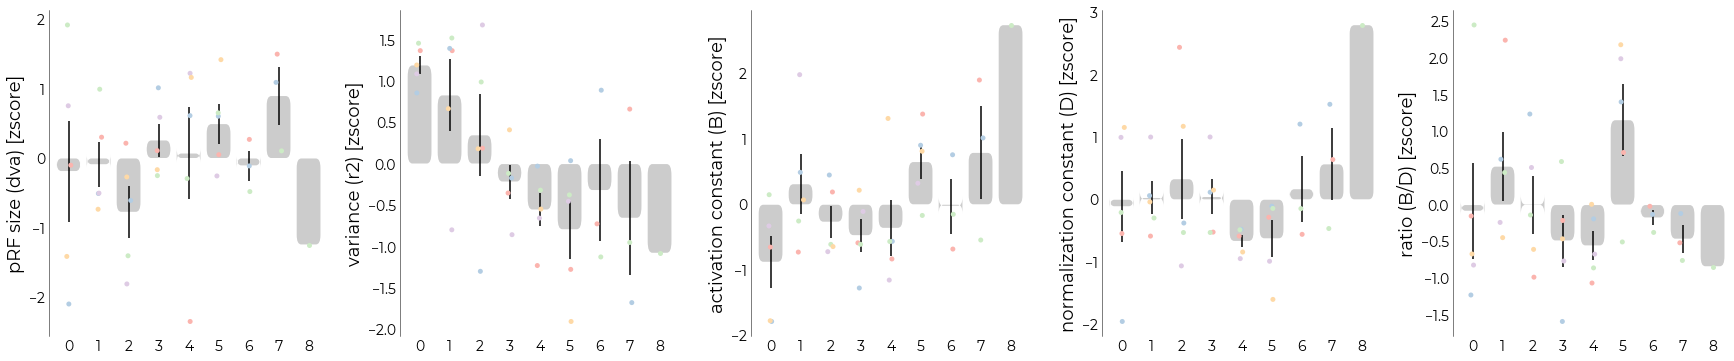

In [22]:
# make list of parameters to include; should strings that are present as column names in dataframe above
include = ["prf_size","r2","B","D", "ratio (B/D)"]

# initialize figure
fig = plt.figure(figsize=(len(include)*6,6))
gs = fig.add_gridspec(ncols=len(include), wspace=0.3)

# loop through parameters
for par_ix,par in enumerate(include):
    
    # add axis to plot
    ax = fig.add_subplot(gs[par_ix])

    # prettify axis labels
    if par == "prf_size":
        x_label = "pRF size (dva) [zscore]"
    elif par == "A":
        x_label = "activation amplitude (A) [zscore]"
    elif par == "B":
        x_label = "activation constant (B) [zscore]"
    elif par == "C":
        x_label = "normalization amplitude (C) [zscore]"
    elif par == "D":
        x_label = "normalization constant (D) [zscore]"
    elif par == "r2":
        x_label = "variance (r2) [zscore]"
    else:
        x_label = f"{par} [zscore]"

    # plot; fancy=True means rounding of the bars
    plotting.LazyBar(
        data=params_depth.reset_index(),
        x="depth",
        y=par,
        sns_ori="v",
        axs=ax,
        color="#cccccc",
        sns_offset=5,
        add_points=True,
        add_labels=True,
        y_label2=x_label,
        points_cmap=cmap_subj,
        points_hue="subject",
        fancy=True,
        fancy_aspect=0.9,
        trim_bottom=True)

for ext in ['png','svg']:
    fig.savefig(
        opj(fig_dir, f"sub-all_model-{model}_desc-depth_pars.{ext}"),
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )                    

## Full figure

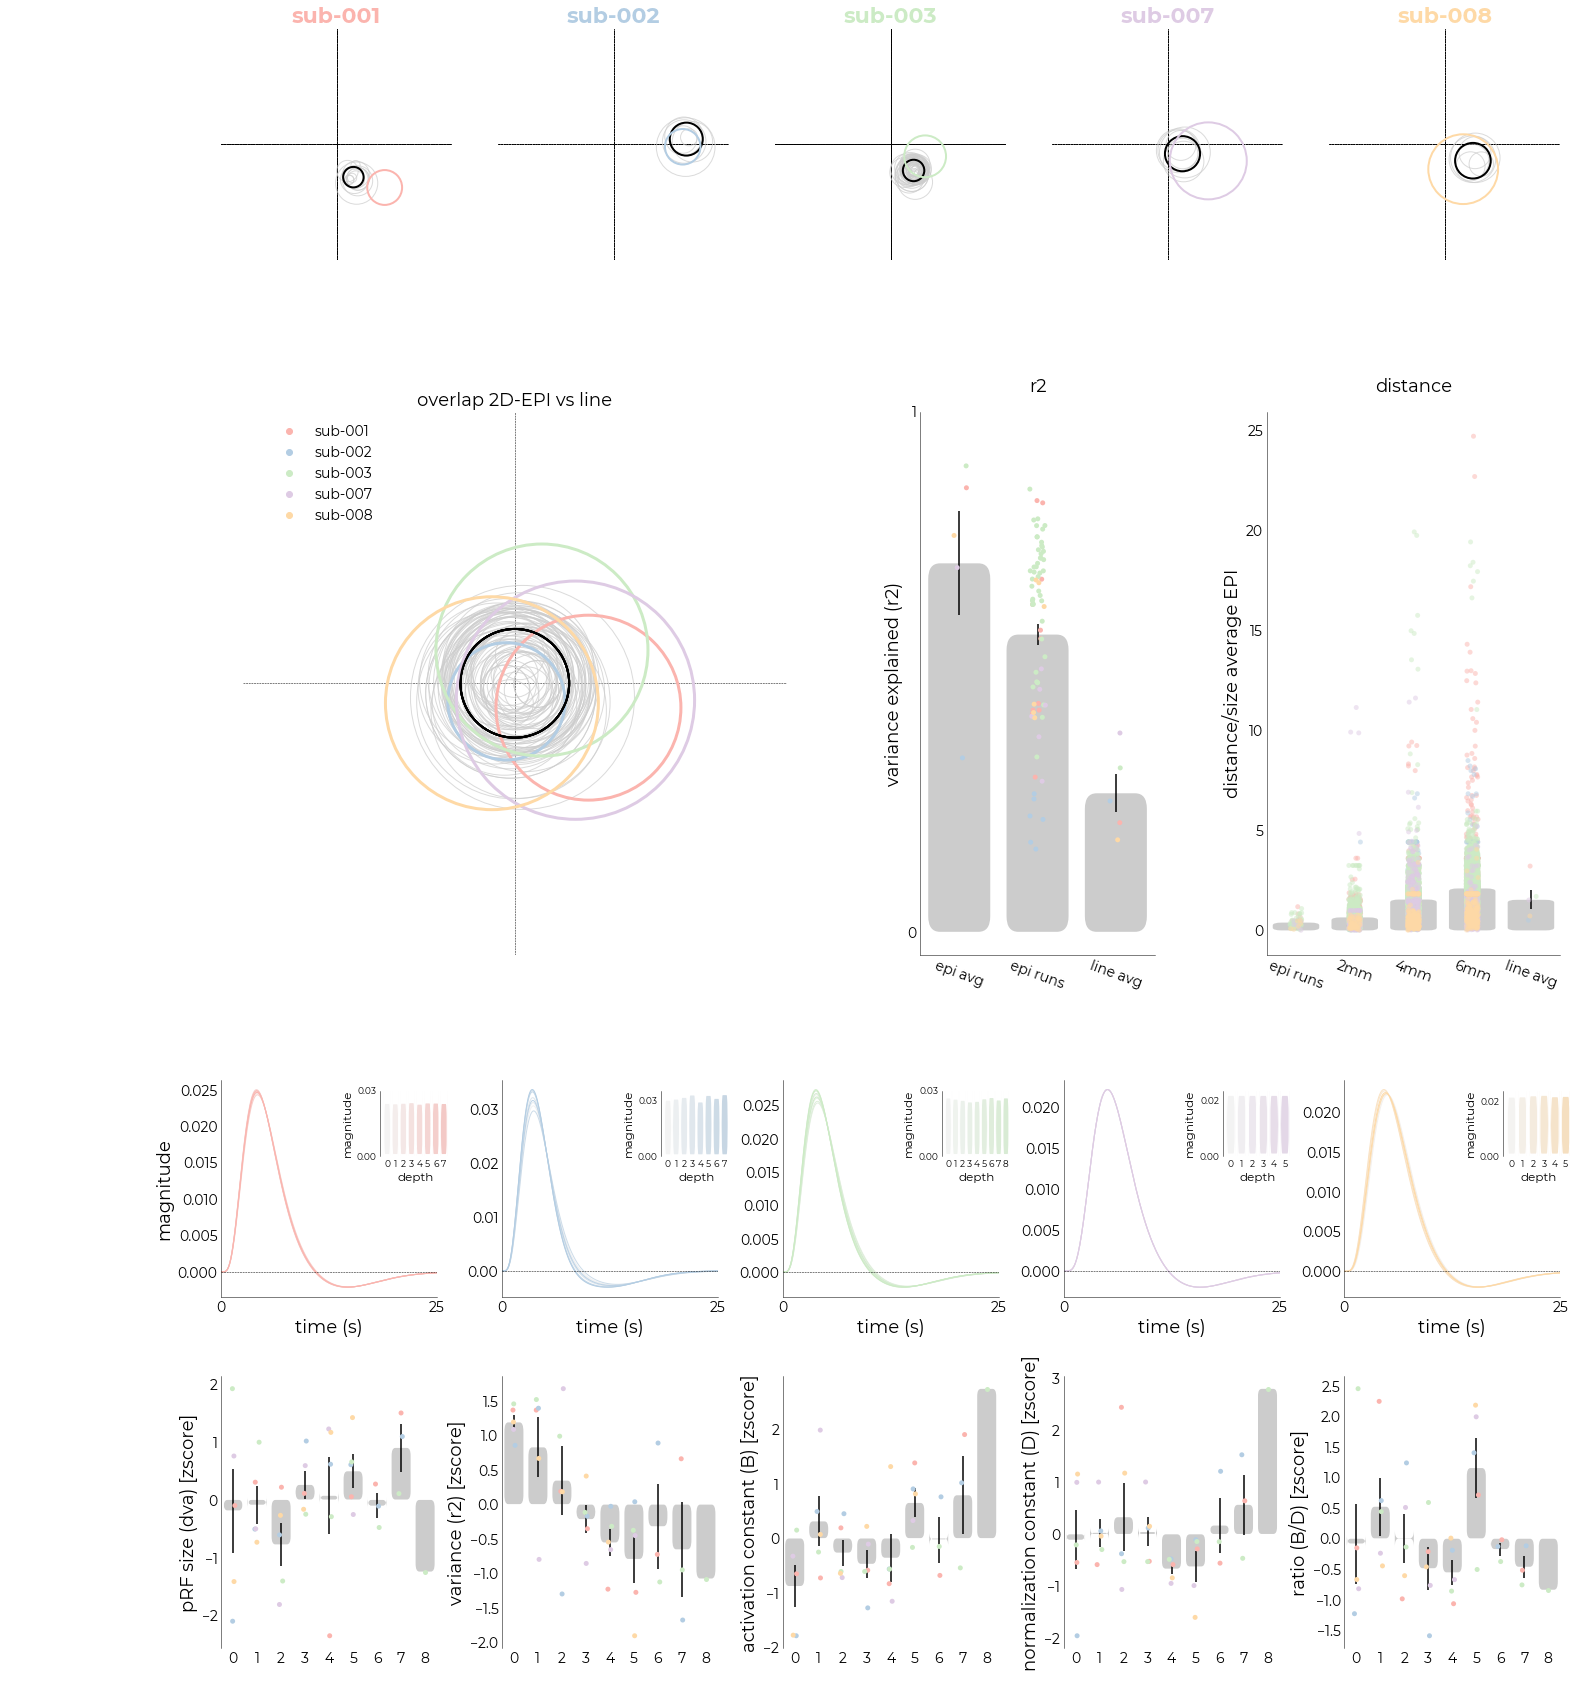

In [31]:
# figure settings
fig = plt.figure(figsize=(24,24))
subfigs = fig.subfigures(nrows=4, height_ratios=[0.5,1,0.4,0.5])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=3, 
    gridspec_kw={
        'width_ratios': [1,0.4,0.5], 
        'wspace': 0.3})

# axis for pRF overlap plot
axs = axs_avg[0]

colors=["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])

subjects = list(full_dict.keys())
cmap_subj = "Pastel1"
sub_colors = sns.color_palette(cmap_subj, len(subjects))

####################################################################################################
# pRF locations + distance plots
####################################################################################################

r2s, dist = {},{}
r2s["subject"], r2s["r2"], r2s["acq"], r2s["name"] = [],[],[],[]
dist["subject"], dist["distance"], dist["acq"], dist["name"] = [],[],[],[]

# if fit_nbr == True, target vertex is last row
est_idx = 0

for ix,sub in enumerate(subjects):

    ax_ = axs_subj[ix]

    for fit in full_dict[sub]['wb']:
        
        # find index of target 
        est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]
        
        if fit != "avg":
            # get parameters from individual runs
            pars,_,_,_ = full_dict[sub]['wb'][fit].plot_vox(
                vox_nr=est_idx,
                model=model,
                stage='iter',
                make_figure=False
            )

            if pars[-1] != 0:
                # get parameters from average
                avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
                    vox_nr=est_idx,
                    model=model,
                    stage='iter',
                    make_figure=False
                )

                # express distance as distance/size
                dist_dva = prf.distance_centers(avg_pars,pars)/avg_pars[2]
                dist["distance"].append(dist_dva)
                dist["subject"].append(sub)
                dist["name"].append("epi runs")
                dist["acq"].append(0)                

                # append r2 to dictionary
                r2s["r2"].append(pars[-1])
                r2s["subject"].append(sub)
                r2s["name"].append("epi runs")
                r2s["acq"].append(1)
                
            # get distance/size of neighbouring vertices
            if fit_nbr:
                nbr_pars = getattr(full_dict[sub]['wb'][fit], f"{model}_iter")
                for nbr in range(nbr_pars.shape[0]):
                    
                    # filter out target vertex
                    if full_dict[sub]["vertices"]["all"][nbr] != full_dict[sub]["vertices"]["target"]:

                        # get parameters from neighbours
                        nbr_estimates = nbr_pars[nbr,:]

                        # plot normalized neighbour
                        nbr_norm = prf.normalize_prf(avg_pars,nbr_estimates)

                        # find x/y of max pRF
                        center = (nbr_norm[0],nbr_norm[1])
                        circ_nbr = plt.Circle(
                            center,
                            nbr_norm[2],
                            ec="r",
                            fill=False,
                            alpha=0.15)
                        # axs.add_artist(circ_nbr)      
                        
                        if nbr in full_dict[sub]["vertices"]["2mm"]:
                            nn = "2mm"
                            ct = 1
                        elif nbr in full_dict[sub]["vertices"]["4mm"]:
                            nn = "4mm"
                            ct = 2
                        elif nbr in full_dict[sub]["vertices"]["6mm"]:
                            nn = "6mm"
                            ct = 3

                        dist_dva = prf.distance_centers(avg_pars,nbr_estimates)/avg_pars[2]
                        dist["distance"].append(dist_dva)
                        dist["subject"].append(sub)
                        dist["name"].append(nn)
                        dist["acq"].append(ct)                                  

        else:
            r2s["r2"].append(getattr(full_dict[sub]['wb']['avg'], f"{model}_iter")[est_idx,-1])
            r2s["subject"].append(sub)
            r2s["name"].append("epi avg")
            r2s["acq"].append(0)            

        if fit == 0 and ix == 0:

            # create visual field delineation, plot on subject specific axis & average
            plotting.LazyPRF(
                np.zeros((500,500)), 
                [-5,5],
                ax=axs,
                cross_color="k",
                edge_color=None,
                shrink_factor=0.9,
                cmap=cmap1,
                vf_only=True)

        # draw empty visual field for subject
        plotting.LazyPRF(
            np.zeros((500,500)), 
            [-5,5],
            ax=ax_,
            cross_color="k",
            edge_color=None,
            shrink_factor=0.9,
            cmap=cmap1,
            vf_only=True)                

        if fit != "avg":
            # plot normalized pRF
            run_norm = prf.normalize_prf(avg_pars,pars)
            
            # find x/y of max pRF
            center = (run_norm[0],run_norm[1])
            circ2 = plt.Circle(
                center,
                run_norm[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)
        
            axs.add_artist(circ2)

            # add non-normalized to subject specific axis
            circ_run_subj = plt.Circle(
                (pars[0],pars[1]),
                pars[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)

            ax_.add_artist(circ_run_subj)

line_avg_idx_dist = len(np.unique(dist["acq"]))            
for ix,sub in enumerate(subjects):

    #re-fetch the index of target vertex
    est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

    # get parameters from average
    avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
        vox_nr=est_idx,
        model=model,
        stage='iter',
        make_figure=False
    )

    circ_avg = plt.Circle(
        (0,0),
        1,
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    axs.add_artist(circ_avg)

    # add average line-scanning
    l_pars,_,_,_ = full_dict[sub]['lines']['native']["avg"].plot_vox(
        model=model,
        stage='iter',
        make_figure=False
    )

    # plot normalized pRF
    line_norm = prf.normalize_prf(avg_pars,l_pars)

    # find x/y of max pRF
    center = (line_norm[0],line_norm[1])
    circ3 = plt.Circle(
        center,
        line_norm[2],
        ec=sub_colors[ix],
        fill=False,
        lw=3)

    axs.add_artist(circ3)

    # add to subject specific axis
    sub_epi = plt.Circle(
        (avg_pars[0],avg_pars[1]),
        avg_pars[2],
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    sub_line = plt.Circle(
        (l_pars[0],l_pars[1]),
        l_pars[2],
        ec=sub_colors[ix],
        fill=False,
        lw=2)

    axs_subj[ix].add_artist(sub_epi)    
    axs_subj[ix].add_artist(sub_line)    

    # axs.annotate(sub, xy=center, fontsize=12, ha="center")
    axs_subj[ix].set_title(sub, fontsize=22, color=sub_colors[ix], fontweight="bold")
    axs.set_title("overlap 2D-EPI vs line", fontsize=18)
    
    # append to r2 array
    avg_idx = 2
    if downsample:
        l_ds_pars,_,_,_ = full_dict[sub]['lines']['ds'].plot_vox(
            model=model,
            stage='iter',
            make_figure=False
        )

        avg_idx = 3
        r2s["r2"].append(l_ds_pars[-1])
        r2s["subject"].append(sub)
        r2s["name"].append("line ds")
        r2s["acq"].append(2)        

    r2s["r2"].append(l_pars[-1])
    r2s["subject"].append(sub)
    r2s["name"].append("line avg")
    r2s["acq"].append(avg_idx)

    # append distance
    line_dist = prf.distance_centers(avg_pars, l_pars)/avg_pars[2]
    dist["distance"].append(line_dist)
    dist["subject"].append(sub)
    dist["name"].append("line avg")
    dist["acq"].append(line_avg_idx_dist)

# make dataframe
df_r2 = pd.DataFrame(r2s)
df_dist = pd.DataFrame(dist)

# enforce float
df_r2["r2"] = df_r2["r2"].astype(float)
df_dist["distance"] = df_dist["distance"].astype(float)
df_r2.head()

r2_axs = axs_avg[1]
dist_axs = axs_avg[2]

plotting.LazyBar(
    data=df_r2.sort_values(['acq','subject']),
    x="name",
    y="r2",
    sns_ori="v",
    axs=r2_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    points_cmap=cmap_subj,
    points_hue="subject",    
    y_label2="variance explained (r2)",
    title2="r2",
    ticks=[0,1],
    sns_rot=-20,
    fancy=True,
    trim_bottom=True
)

plotting.LazyBar(
    data=df_dist.sort_values(['acq','subject']),
    x="name",
    y="distance",
    sns_ori="v",
    axs=dist_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    y_label2="distance/size average EPI",
    points_cmap=cmap_subj,
    points_hue="subject",
    title2="distance",
    points_legend=True,
    bbox_to_anchor=(-3,1),
    sns_rot=-20,
    fancy=True,
    fancy_rounding=0.15,
    fancy_aspect=0.9,
    points_alpha=0.5,
    trim_bottom=True
)

# v1_axs = dist_axs.inset_axes([0.7, 0.7, 0.6, 0.6])
# im = imageio.imread(opj(design_dir, "sub-001", "sub-001_hemi-L_desc-V1_distances.png"))
# v1_axs.imshow(im[2000:,:2000,:])
# v1_axs.axis('off')

####################################################################################################
# HRFs
####################################################################################################
hrf_axs = subfigs[2].subplots(ncols=len(dict_data), gridspec_kw={'wspace': 0.3})

plot_mag = True
plot_ttp = True
plot_fwhm = False

for ix,sub in enumerate(subjects):
    
    # get the pRF-object containing estimates across depth
    if "ribbon" in list(full_dict[sub]["lines"]["native"].keys()):
        
        fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

        # get subject-specific HRFs from HRF-dataframe  
        sub_hrf = utils.select_from_df(hrf_df, expression=f"subject = {sub}")

        # parse them into list depending on the number of voxels in estimates
        hrf_list = [utils.select_from_df(sub_hrf, expression=f"depth = {ii}")['hrf'].values for ii in range(fit_obj.norm_iter.shape[0])]

        # get subject specific color palette
        colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", len(hrf_list))
        y_ticks = None
        trim_left = False
        if ix == 0:
            if normalize:
                y_ticks = [0,1]
                trim_left = True

            y_lbl = "magnitude"
        else:
            if normalize:
                y_ticks = []

            y_lbl = None

        # create time axis
        time_axis = list(np.arange(0,hrf_list[0].shape[0])*fit_obj.TR)

        # plot
        plotting.LazyPlot(
            hrf_list,
            axs=hrf_axs[ix],
            xx=time_axis,
            x_label="time (s)",
            y_label=y_lbl,
            cmap=colors,
            x_lim=[0,25],
            x_ticks=[0,25],
            y_ticks=y_ticks,
            add_hline=0,
            trim_left=trim_left
        )
        
        # add time-to-peak across the ribbon as inset-axis
        tcs = np.array(hrf_list)
        peak_positions = (np.argmax(tcs, axis=1)/tcs.shape[-1])*xx[-1]

        # FWHM
        fwhm_objs = []
        for hrf in hrf_list:
            fwhm_objs.append(fitting.FWHM(time_axis, hrf))

        y_fwhm = np.array([i.fwhm for i in fwhm_objs])
        if plot_mag or plot_ttp or plot_fwhm:
            ax2 = hrf_axs[ix].inset_axes([0.75, 0.65, 0.3, 0.3])

        # get magnitudes
        mag = np.array([np.amax(i) for i in hrf_list])

        # decide plot properties depending on which type to put on the inset axis
        if plot_mag:
            plot_ttp = False
            plot_fwhm = False
            y_ax = mag
            ori = "v"
            ticks = [0,round(mag.max(),2)]
            y_lab = "magnitude"
            x_lab = "depth"

        if plot_ttp:
            plot_fwhm = False
            y_ax = peak_positions
            ori = "h"
            ticks = [0,round(peak_positions.max(),0)]
            y_lab = "depth"
            x_lab = "time-to-peak (s)"

        if plot_fwhm:
            y_ax = y_fwhm
            ori = "v"
            ticks = [0,round(y_fwhm.max(),0)]
            y_lab = "FWHM"
            x_lab = "depth"            

        plotting.LazyBar(
            x=np.arange(0,len(hrf_list)),
            y=y_ax,
            axs=ax2,
            label_size=9,
            font_size=12,
            palette=colors,
            # sns_offset=3,
            sns_ori=ori,
            add_labels=True,
            ticks=ticks,
            y_label2=y_lab,
            x_label2=x_lab,
            alpha=0.8,
            fancy=True,
            sns_offset=3,
            trim_bottom=True)

####################################################################################################
# pRF estimates across depth
####################################################################################################
include = ["prf_size","r2","B","D", "ratio (B/D)"]

# initialize figure
pars_axs = subfigs[3].subplots(ncols=len(include), gridspec_kw={'wspace': 0.3})

# loop through parameters
for par_ix,par in enumerate(include):
    
    # add axis to plot
    ax = pars_axs[par_ix]

    # prettify axis labels
    if par == "prf_size":
        x_label = "pRF size (dva) [zscore]"
    elif par == "A":
        x_label = "activation amplitude (A) [zscore]"
    elif par == "B":
        x_label = "activation constant (B) [zscore]"
    elif par == "C":
        x_label = "normalization amplitude (C) [zscore]"
    elif par == "D":
        x_label = "normalization constant (D) [zscore]"
    elif par == "r2":
        x_label = "variance (r2) [zscore]"
    else:
        x_label = f"{par} [zscore]"

    # plot; fancy=True means rounding of the bars
    plotting.LazyBar(
        data=params_depth.reset_index(),
        x="depth",
        y=par,
        sns_ori="v",
        axs=ax,
        add_labels=["GM","","","","","WM"],
        color="#cccccc",
        # sns_offset=5,
        add_points=True,
        y_label2=x_label,
        points_cmap=cmap_subj,
        points_hue="subject",
        fancy=True,
        fancy_aspect=0.9,
        trim_bottom=True)

for ext in ['png','svg']:
    fig.savefig(
        opj(fig_dir, f"sub-all_model-{model}_desc-full_figure.{ext}"),
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

In [82]:
df_dist.to_csv(opj(design_dir, "distance.csv"))
df_r2.to_csv(opj(design_dir, "r2.csv"))

## Test significance bars

In [61]:
np.unique(dist['acq'])

array([0, 1, 2, 3, 4])

In [46]:
# from: https://stackoverflow.com/a/52333561
def barplot_annotate_brackets(
    num1, 
    num2, 
    data, 
    center, 
    height, 
    yerr=None, 
    dh=.05, 
    barh=.05, 
    fs=None, 
    maxasterix=None,
    axs=None):
    """ 
    Annotate barplot with p-values.

    :param num1: number of left bar to put bracket over
    :param num2: number of right bar to put bracket over
    :param data: string to write or number for generating asterixes
    :param center: centers of all bars (like plt.bar() input)
    :param height: heights of all bars (like plt.bar() input)
    :param yerr: yerrs of all bars (like plt.bar() input)
    :param dh: height offset over bar / bar + yerr in axes coordinates (0 to 1)
    :param barh: bar height in axes coordinates (0 to 1)
    :param fs: font size
    :param maxasterix: maximum number of asterixes to write (for very small p-values)
    """

    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05

        while data < p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break

        if len(text) == 0:
            text = 'n. s.'

    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    if not axs:
        import matplotlib.pyplot as plt
        cmd = plt
    else:
        cmd = axs

    cmd.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    cmd.text(*mid, text, **kwargs)

(-0.5, 1999.5, 1999.5, -0.5)

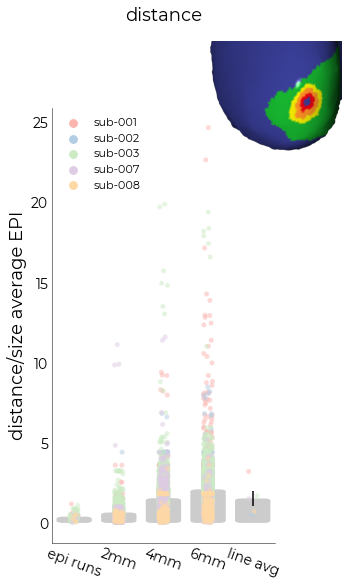

In [96]:
import imageio

fig,axs = plt.subplots(figsize=(4,8))

plotting.LazyBar(
    data=df_dist.sort_values(['acq','subject']),
    x="name",
    y="distance",
    sns_ori="v",
    axs=axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    y_label2="distance/size average EPI",
    points_cmap=cmap_subj,
    points_hue="subject",
    title2="distance",
    points_legend=True,
    sns_rot=-20,
    fancy=True,
    fancy_rounding=0.15,
    fancy_aspect=0.9,
    points_alpha=0.5,
)

ax2 = axs.inset_axes([0.7, 0.7, 0.6, 0.6])
im = imageio.imread(opj(design_dir, "sub-001", "sub-001_hemi-L_desc-V1_distances.png"))
ax2.imshow(im[2000:,:2000,:])
ax2.axis('off')

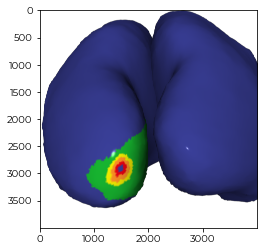

In [86]:

# ax2 = axs.inset_axes([0.75, 0.65, 0.3, 0.3])
im = imageio.imread(opj(design_dir, "sub-001", "sub-001_hemi-L_desc-V1_distances.png"))
plt.imshow(im)

In [67]:
test_df = df_dist.sort_values(['acq','subject']).copy()
df_dist.loc[df_dist["acq"] == 0]["distance"]

0        0.470809
170      0.827212
340      0.468933
510      0.364001
680      0.480772
           ...   
13051    0.344219
13172    0.091971
13293    0.464834
13414    0.209737
13535    0.507453
Name: distance, Length: 76, dtype: float64

In [71]:
fvalue,pvalue = stats.f_oneway(*[test_df.loc[test_df["acq"] == ii]["distance"] for ii in range(len(np.unique(test_df["acq"])))])

import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

lm = sfa.ols('distance ~ C(acq)', data=test_df).fit()
anova = sa.stats.anova_lm(lm)
print(anova)

               df        sum_sq     mean_sq           F  PR(>F)
C(acq)        4.0   2823.755035  705.938759  508.646191     0.0
Residual  13656.0  18952.859299    1.387878         NaN     NaN


## Timecourses

Here I plot the timecourses for the ribbon-voxels, as well as their individual fits

In [33]:
subjects

['sub-001', 'sub-002', 'sub-003', 'sub-007', 'sub-008']

In [34]:
for sub in subjects:
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
    fig = plt.figure(figsize=(24,6*fit_obj.norm_iter.shape[0]))
    subfigs = fig.subfigures(nrows=fit_obj.norm_iter.shape[0]+1, hspace=0.4)

    # plot voxel timecourses
    ax = subfigs[0].subplots()
    plotting.LazyPlot(
        [fit_obj.data[ii,:] for ii in range(fit_obj.norm_iter.shape[0])],
        axs=ax,
        labels=[f"depth {ii}" for ii in range(fit_obj.norm_iter.shape[0])],
        line_width=0.7,
        x_label="volumes",
        y_label="magnitude",
        add_hline=0,
        cmap="magma"
    )

    # plot fits
    for fit in range(fit_obj.norm_iter.shape[0]):
        axs = subfigs[fit+1].subplots(ncols=2, gridspec_kw={'width_ratios': [0.3,0.65]})

        fit_obj.plot_vox(
            vox_nr=fit,
            model=model,
            title=f"depth - {fit}; {[round(ii,2) for ii in fit_obj.norm_iter[fit,:]]}",
            axs=list(axs)
        )

    plt.close(fig)
    for ext in ['png','svg']:
        fig.savefig(
            opj(fig_dir, sub, f"{sub}_model-{model}_desc-fits_depth.{ext}"),
            bbox_inches="tight",
            dpi=300,
            facecolor="white"
        )

In [32]:
fig_dir

'/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/results'

## Other shenanigans

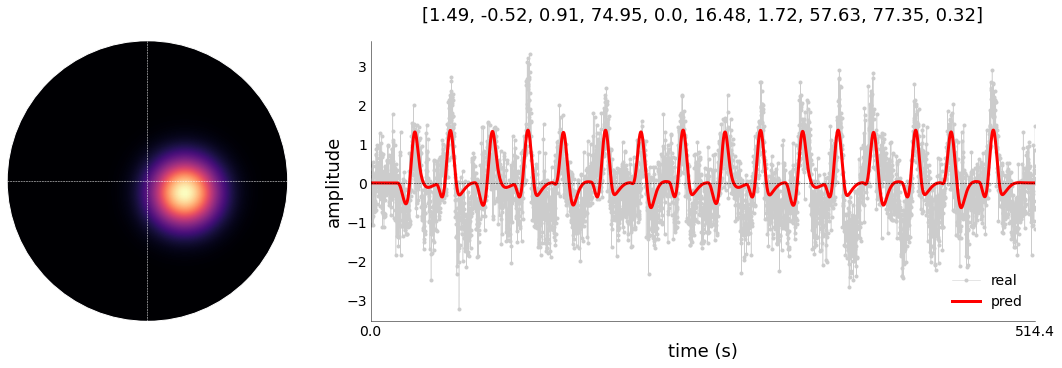

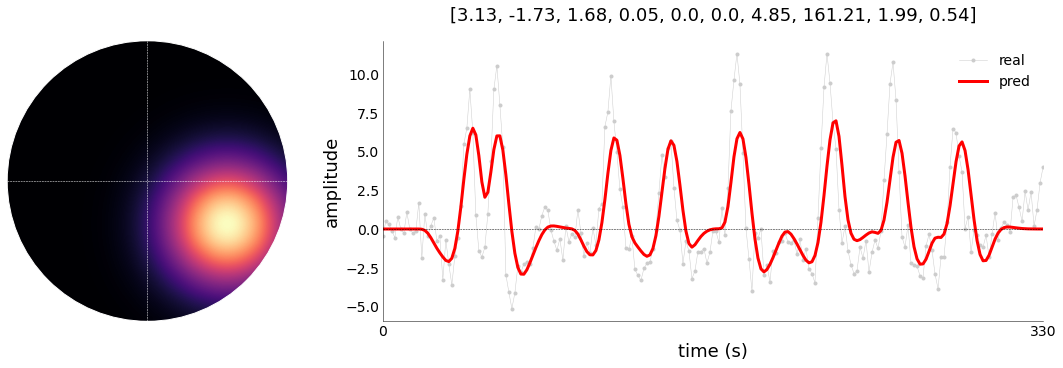

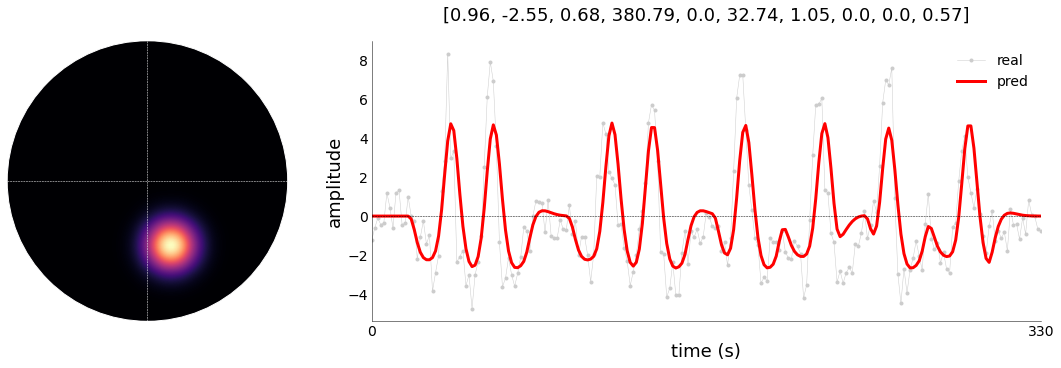

In [322]:
test_subj = "sub-003"
model = "norm"
_,_,_,_ = full_dict[test_subj]["lines"]["native"]["avg"].plot_vox(model=model, title="pars")
# _,_,_,_ = full_dict[test_subj]["lines"]["ds"].plot_vox(model=model, title="pars")
_,_,_,_ = full_dict[test_subj]["wb"]["avg"].plot_vox(vox_nr=88, model=model, title="pars")
_,_,_,_ = full_dict[test_subj]["wb"]["avg"].plot_vox(vox_nr=0, model=model, title="pars")

In [320]:
full_dict[test_subj]["wb"]["avg"].norm_iter.shape

(195, 10)

In [174]:
all_df = []
for ix,sub in enumerate(subjects):
    
    sub_df = []

    for ii in full_dict[sub]["wb"]:

        df = prf.SizeResponse.parameters_to_df(getattr(full_dict[sub]["wb"][ii], f"{model}_iter"))
        df["subject"], df["run"] = sub, ii
        df['target'] = list(np.zeros((df.shape[0]-1),dtype=int))+[1]
        
        sub_df.append(df)

    all_df.append(pd.concat(sub_df))

all_df = pd.concat(all_df).set_index(["subject", "run"])
all_df = all_df.dropna(axis=0)
all_df

x         y  prf_size    prf_ampl  bold_bsl    neur_bsl  \
subject run                                                                   
sub-001 0    1.849239 -3.549210  1.410910    0.006041       0.0  146.960120   
        0    1.713911 -3.483116  1.395261    0.002140       0.0  102.218469   
        0   -0.297971 -0.363576  1.374253    0.001508       0.0  108.760029   
        0    0.504206 -1.343725  0.200002   60.847035       0.0    1.666662   
        0    0.461908 -1.388714  0.200000   55.120084       0.0    8.828105   
...               ...       ...       ...         ...       ...         ...   
sub-008 avg  1.136699 -0.715519  0.801505  290.871127       0.0    0.004389   
        avg  1.154189 -0.693025  0.738332  265.861665       0.0    0.004924   
        avg  1.206733 -0.697834  0.755700  282.363110       0.0    0.339420   
        avg  1.271060 -0.630021  0.824593  291.090128       0.0    0.001305   
        avg  1.214978 -0.714740  0.771537  469.845473       0.0    0.002245   

             surr_ampl  surr_size  surr_bsl           A           B         C  \
subject run                                                                     
sub-001 0     0.001045   2.222347       0.0    0.006041  146.960120  0.001045   
        0     0.000257   2.235966       0.0    0.002140  102.218469  0.000257   
        0     0.000079   1.755078       0.0    0.001508  108.760029  0.000079   
        0     0.198308  32.070954       0.0   60.847035    1.666662  0.198308   
        0     0.149398  32.071218       0.0   55.120084    8.828105  0.149398   
...                ...        ...       ...         ...         ...       ...   
sub-008 avg   4.018876  32.066540       0.0  290.871127    0.004389  4.018876   
        avg   3.484378  32.056142       0.0  265.861665    0.004924  3.484378   
        avg   2.669919  32.052730       0.0  282.363110    0.339420  2.669919   
        avg   5.524171  32.051469       0.0  291.090128    0.001305  5.524171   
        avg   5.700304  32.059947       0.0  469.845473    0.002245  5.700304   

                     D  ratio (B/D)        r2  size ratio  suppression index  \
subject run                                                                    
sub-001 0    57.067690     2.575190  0.377474    1.575116           0.429185   
        0    27.964188     3.655335  0.399010    1.602544           0.308339   
        0    11.122648     9.778250  0.182648    1.277114           0.085329   
        0     1.194798     1.394932  0.605358  160.353130          83.802224   
        0     5.031008     1.754739  0.629712  160.355734          69.695180   
...                ...          ...       ...         ...                ...   
sub-008 avg   0.005494     0.798860  0.776621   40.007909          22.115447   
        avg   0.005097     0.966128  0.716947   43.416951          24.705188   
        avg   0.301609     1.125363  0.764642   42.414634          17.010675   
        avg   0.002128     0.613154  0.751702   38.869450          28.671898   
        avg   0.002606     0.861354  0.761987   41.553355          20.948608   

                  ecc     polar  target  
subject run                              
sub-001 0    4.002071 -1.090468       0  
        0    3.881957 -1.113519       0  
        0    0.470079 -2.257349       0  
        0    1.435208 -1.211824       0  
        0    1.463518 -1.249692       1  
...               ...       ...     ...  
sub-008 avg  1.343150 -0.561808       0  
        avg  1.346268 -0.540745       0  
        avg  1.393979 -0.524298       0  
        avg  1.418633 -0.460174       0  
        avg  1.409619 -0.531753       1  

[256 rows x 20 columns]

In [173]:
list(np.zeros((df.shape[0]-1),dtype=int))+[1]

[0, 0, 0, 0, 0, 0, 1]

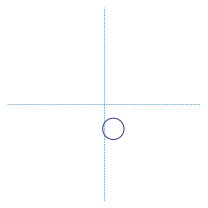

In [162]:
fig = plt.figure(figsize=(16,8))
gs = fig.add_gridspec(ncols=4)

subj_avg = utils.select_from_df(all_df, expression=("subject = sub-001", "&", "run = avg"))

prf_axs = fig.add_subplot(gs[0])
plotting.LazyPRF(
    np.zeros((500,500)), 
    [-5,5],
    ax=prf_axs,
    cross_color=None,
    shrink_factor=0.9,
    cmap=cmap1,
    vf_only=True)

# find x/y of max pRF
center = (subj_avg["x"].values[-1],subj_avg["y"].values[-1])
circ2 = plt.Circle(
    center,
    subj_avg["prf_size"].values[-1],
    ec=sub_colors[0],
    fill=False)

prf_axs.add_artist(circ2)

sns.distplot(subset['arr_delay'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 3}, 
                  label = airline)

In [175]:
utils.select_from_df(all_df, expression=("subject = sub-001", "&", "run != avg"))

x         y  prf_size    prf_ampl  bold_bsl    neur_bsl  \
subject run                                                                   
sub-001 0    1.849239 -3.549210  1.410910    0.006041       0.0  146.960120   
        0    1.713911 -3.483116  1.395261    0.002140       0.0  102.218469   
        0   -0.297971 -0.363576  1.374253    0.001508       0.0  108.760029   
        0    0.504206 -1.343725  0.200002   60.847035       0.0    1.666662   
        0    0.461908 -1.388714  0.200000   55.120084       0.0    8.828105   
...               ...       ...       ...         ...       ...         ...   
        11   2.305306 -4.425218  1.005501   36.544058       0.0  134.112518   
        11   2.137706 -3.799254  0.874736    7.981217       0.0   15.348567   
        11   0.682539 -0.342128  1.210199    0.000445       0.0    7.457677   
        11   0.551644 -0.776745  0.368570  342.834474       0.0    6.720398   
        11   0.576017 -0.849328  0.436061  357.136024       0.0    0.028356   

             surr_ampl  surr_size  surr_bsl           A           B         C  \
subject run                                                                     
sub-001 0     0.001045   2.222347       0.0    0.006041  146.960120  0.001045   
        0     0.000257   2.235966       0.0    0.002140  102.218469  0.000257   
        0     0.000079   1.755078       0.0    0.001508  108.760029  0.000079   
        0     0.198308  32.070954       0.0   60.847035    1.666662  0.198308   
        0     0.149398  32.071218       0.0   55.120084    8.828105  0.149398   
...                ...        ...       ...         ...         ...       ...   
        11    3.040767   1.016611       0.0   36.544058  134.112518  3.040767   
        11    1.419499  31.988866       0.0    7.981217   15.348567  1.419499   
        11    0.000047   1.461436       0.0    0.000445    7.457677  0.000047   
        11    6.903405   2.334567       0.0  342.834474    6.720398  6.903405   
        11    8.967585   2.246679       0.0  357.136024    0.028356  8.967585   

                      D  ratio (B/D)        r2  size ratio  suppression index  \
subject run                                                                     
sub-001 0     57.067690     2.575190  0.377474    1.575116           0.429185   
        0     27.964188     3.655335  0.399010    1.602544           0.308339   
        0     11.122648     9.778250  0.182648    1.277114           0.085329   
        0      1.194798     1.394932  0.605358  160.353130          83.802224   
        0      5.031008     1.754739  0.629712  160.355734          69.695180   
...                 ...          ...       ...         ...                ...   
        11    11.955237    11.217888  0.271596    1.011049           0.085057   
        11   100.171135     0.153223  0.205454   36.569723         237.853304   
        11     1.555235     4.795209  0.367325    1.207599           0.152246   
        11    10.022346     0.670541  0.388168    6.334118           0.807888   
        11     0.051077     0.555161  0.366485    5.152215           0.666545   

                  ecc     polar  target  
subject run                              
sub-001 0    4.002071 -1.090468       0  
        0    3.881957 -1.113519       0  
        0    0.470079 -2.257349       0  
        0    1.435208 -1.211824       0  
        0    1.463518 -1.249692       1  
...               ...       ...     ...  
        11   4.989689 -1.090532       0  
        11   4.359371 -1.058282       0  
        11   0.763486 -0.464654       0  
        11   0.952704 -0.953258       0  
        11   1.026232 -0.974850       1  

[61 rows x 20 columns]

In [247]:
len(np.unique(df_dist['name'].values))

3

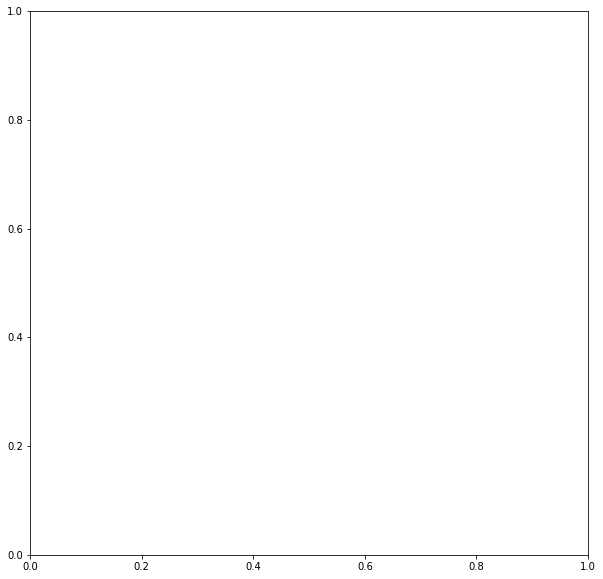

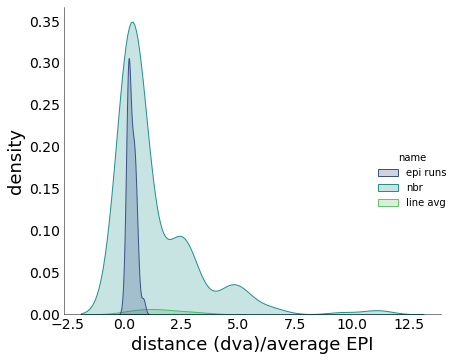

In [281]:
fig,axs = plt.subplots(figsize=(10,10))
plotting.LazyDist(
    data=df_dist,
    x="distance",
    kind="kde",
    hue="name",
    fill=True,
    # add_legend=False,
    x_label2="distance (dva)/average EPI",
    y_label2="density",
    axs=axs
)

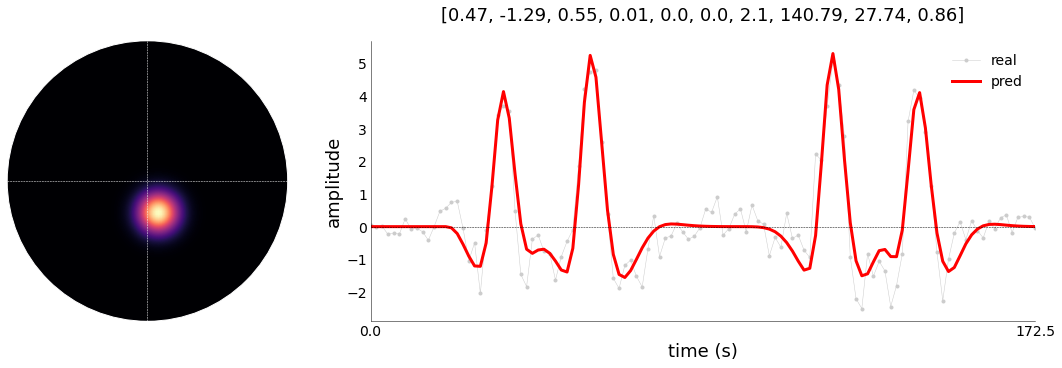

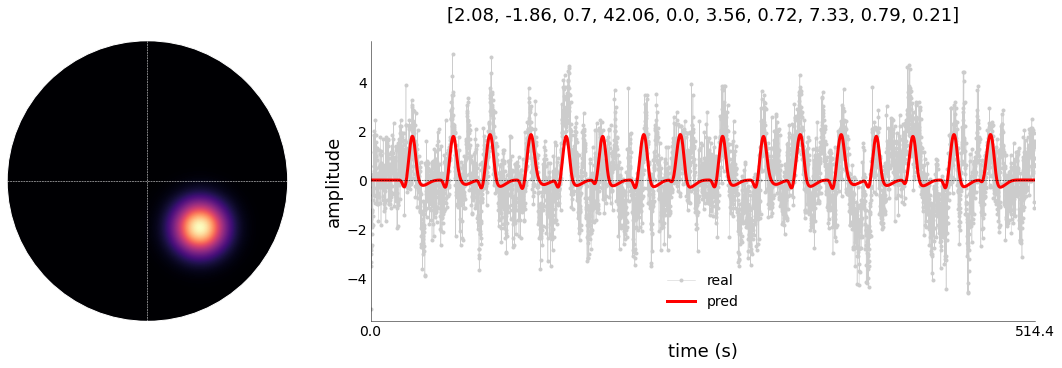

In [37]:
subject = "sub-001"
avg_pars,_,_,_ = full_dict[subject]['wb']['avg'].plot_vox(title="pars", model=model)
wtf,_,_,_ = full_dict[subject]['lines'].plot_vox(title="pars", model=model)    

In [30]:
line_pars[:2]

array([ 0.79540522, -1.08222811])

[-0.15407643 -0.33320339  1.05608097  9.4390993   0.          0.6744033
  0.77099857 10.60020749  0.83242724  0.25213102]
[240 264]


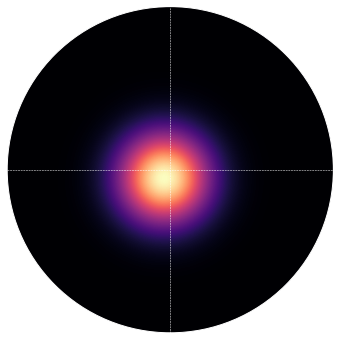

In [25]:
line_norm = prf.normalize_prf(avg_pars,line_pars)
print(line_norm)
line_prf = prf.make_prf(
    full_dict[subject]['lines'].prf_stim, 
    mu_x=line_norm[0],
    mu_y=line_norm[1],
    size=line_norm[2],
    resize_pix=500
)

# make plot 
plotting.LazyPRF(
    line_prf, 
    vf_extent=full_dict[subject]['lines'].settings['vf_extent'], 
    figsize=(6,6)
)

x,y = np.where(line_prf == np.amax(line_prf))
center = np.array([y[0],x[0]])       
print(center)